### homework1：通过LSTM实现电影情感分类，理解LSTM的参数，实战LSTM文本生成

#### LSTM实现电影情感分类——word level的分类

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


准备数据

In [2]:
from tensorflow import keras

#用karas有的数据集imdb，电影分类,分电影是积极的，还是消极的
imdb = keras.datasets.imdb
#载入数据使用下面两个参数
vocab_size = 10000  #词典大小，仅保留训练数据中前10000个最经常出现的单词，低频单词被舍弃
index_from = 3  #0,1,2,3空出来做别的事
#前一万个词出现词频最高的会保留下来进行处理，后面的作为特殊字符处理，
# 小于3的id都是特殊字符，下面代码有写
# 需要注意的一点是取出来的词表还是从1开始的，需要做处理
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=vocab_size, index_from=index_from)

2025-01-24 19:02:43.453077: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 19:02:43.828280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737716563.964128     327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737716564.006073     327 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 19:02:44.359375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
print("train", len(train_data), train_labels.shape)  #25000个样本，每个样本是一段话，每个单词用一个数字表示
print("test", len(test_data), test_labels.shape)

train 25000 (25000,)
test 25000 (25000,)


In [4]:
#载入词表，看下词表长度，词表就像英语字典
word_index = imdb.get_word_index()
print(len(word_index))
print(type(word_index))
#词表虽然有8万多，但是我们只载入了最高频的1万词！！！！

88584
<class 'dict'>


构造 word2idx 和 idx2word

In [5]:
word2idx = {word: idx + 3 for word, idx in word_index.items()}
word2idx.update({
    "[PAD]": 0,  # 填充 token
    "[BOS]": 1,  # begin of sentence
    "[UNK]": 2,  # 未知 token
    "[EOS]": 3,  # end of sentence
})

idx2word = {idx: word for word, idx in word2idx.items()}

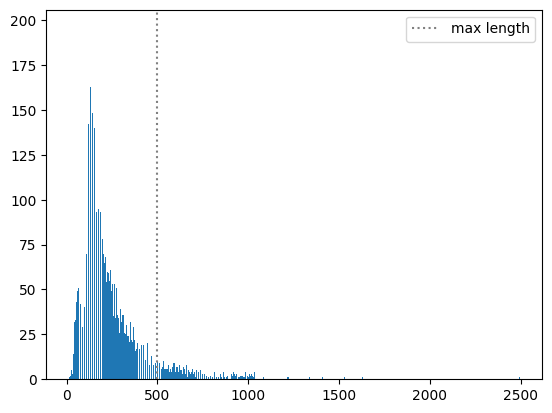

In [6]:
# 选择 max_length
length_collect = {}
for text in train_data:
    length = len(text)
    length_collect[length] = length_collect.get(length, 0) + 1

MAX_LENGTH = 500
plt.bar(length_collect.keys(), length_collect.values())
plt.axvline(MAX_LENGTH, label="max length", c="gray", ls=":")
plt.legend()
plt.show()

Tokenizer

In [7]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, 2 + max([len(text) for text in text_list]))
        indices_list = []
        for text in text_list:
            indices = [self.bos_idx] + [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - 2]] + [
                self.eos_idx]
            if padding_first:
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        return torch.tensor(indices_list)

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list

In [8]:
tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=True)
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   0,    0,    0,    1, 4825,  182,    3])
tensor([    1,     2,  3004,     2,    19, 19233,     3])
tensor([   0,    1,   14,    9,    6, 2181,    3])
decode text
[PAD] [PAD] [PAD] [BOS] hello world [EOS]
[BOS] [UNK] text [UNK] with batch [EOS]
[PAD] [BOS] this is a test [EOS]


In [9]:
# 看看训练集的数据
tokenizer.decode(train_data[:2], remove_bos=False, remove_eos=False, remove_pad=False)

["[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

数据集与 DataLoader

In [10]:
from torch.utils.data import Dataset, DataLoader


class IMDBDataset(Dataset):
    def __init__(self, data, labels, remain_length=True):
        if remain_length:
            self.data = tokenizer.decode(data, remove_bos=False, remove_eos=False, remove_pad=False)
        else:
            # 缩减一下数据
            self.data = tokenizer.decode(data)
        self.labels = labels

    def __getitem__(self, index):
        text = self.data[index]
        label = self.labels[index]
        return text, label

    def __len__(self):
        return len(self.data)


def collate_fct(batch):
    text_list = [item[0].split() for item in batch]
    label_list = [item[1] for item in batch]
    # 这里使用 padding first
    text_list = tokenizer.encode(text_list, padding_first=True).to(dtype=torch.int)
    label_list = torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)
    return text_list, label_list


# 用RNN，缩短序列长度
train_ds = IMDBDataset(train_data, train_labels, remain_length=False)
test_ds = IMDBDataset(test_data, test_labels, remain_length=False)

In [11]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

In [12]:
for text, label in train_dl:  #检查样本是否存在问题
    print(text.shape, label.shape)
    break

torch.Size([128, 500]) torch.Size([128, 1])


定义模型

In [13]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim=16, hidden_dim=64, vocab_size=vocab_size, num_layers=1, bidirectional=False):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                            bidirectional=bidirectional)
        self.layer = nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # [bs, seq length]
        x = self.embedding(x)
        # [bs, seq length, embedding_dim] -> shape [bs, seq length，hidden_dim]
        seq_output, (hidden, cell) = self.lstm(x)
        # print(f'seq_output.shape{seq_output.shape}')
        # print(f'hidden.shape{hidden.shape}') #最后一个时间步的输出
        # print(f'cell.shape{cell.shape}') #最后一个时间步的cell state
        # print(seq_output[:, -1, :].squeeze()==hidden.squeeze()) #squeeze() 去掉轴的尺寸为1的哪个轴
        # print(seq_output[:, -1, :].squeeze()==cell.squeeze())
        x = seq_output[:, -1, :]
        # 取最后一个时间步的输出 (这也是为什么要设置padding_first=True的原因)
        x = self.layer(x)
        x = self.fc(x)
        return x

In [14]:
print("{:=^80}".format(" 单层单向 LSTM "))
for key, value in LSTM().named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

================================== 单层单向 LSTM ===================================
            embedding.weight            paramerters num: 160000
           lstm.weight_ih_l0            paramerters num: 4096
           lstm.weight_hh_l0            paramerters num: 16384
            lstm.bias_ih_l0             paramerters num: 256
            lstm.bias_hh_l0             paramerters num: 256
              layer.weight              paramerters num: 4096
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1


In [15]:
print("{:=^80}".format(" 单层双向 LSTM "))
for key, value in LSTM(bidirectional=True).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

================================== 单层双向 LSTM ===================================
            embedding.weight            paramerters num: 160000
           lstm.weight_ih_l0            paramerters num: 4096
           lstm.weight_hh_l0            paramerters num: 16384
            lstm.bias_ih_l0             paramerters num: 256
            lstm.bias_hh_l0             paramerters num: 256
       lstm.weight_ih_l0_reverse        paramerters num: 4096
       lstm.weight_hh_l0_reverse        paramerters num: 16384
        lstm.bias_ih_l0_reverse         paramerters num: 256
        lstm.bias_hh_l0_reverse         paramerters num: 256
              layer.weight              paramerters num: 8192
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1


In [16]:
print("{:=^80}".format(" 双层单向 LSTM "))
for key, value in LSTM(num_layers=2).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

================================== 双层单向 LSTM ===================================
            embedding.weight            paramerters num: 160000
           lstm.weight_ih_l0            paramerters num: 4096
           lstm.weight_hh_l0            paramerters num: 16384
            lstm.bias_ih_l0             paramerters num: 256
            lstm.bias_hh_l0             paramerters num: 256
           lstm.weight_ih_l1            paramerters num: 16384
           lstm.weight_hh_l1            paramerters num: 16384
            lstm.bias_ih_l1             paramerters num: 256
            lstm.bias_hh_l1             paramerters num: 256
              layer.weight              paramerters num: 4096
               layer.bias               paramerters num: 64
               fc.weight                paramerters num: 64
                fc.bias                 paramerters num: 1


In [17]:
print("{:=^80}".format(" 双层双向 LSTM "))
for key, value in LSTM(num_layers=2, bidirectional=True).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

================================== 双层双向 LSTM ===================================
            embedding.weight            paramerters num: 160000
           lstm.weight_ih_l0            paramerters num: 4096
           lstm.weight_hh_l0            paramerters num: 16384
            lstm.bias_ih_l0             paramerters num: 256
            lstm.bias_hh_l0             paramerters num: 256
       lstm.weight_ih_l0_reverse        paramerters num: 4096
       lstm.weight_hh_l0_reverse        paramerters num: 16384
        lstm.bias_ih_l0_reverse         paramerters num: 256
        lstm.bias_hh_l0_reverse         paramerters num: 256
           lstm.weight_ih_l1            paramerters num: 32768
           lstm.weight_hh_l1            paramerters num: 16384
            lstm.bias_ih_l1             paramerters num: 256
            lstm.bias_hh_l1             paramerters num: 256
       lstm.weight_ih_l1_reverse        paramerters num: 32768
       lstm.weight_hh_l1_reverse        paramerter

In [18]:
model = LSTM()
#随机一个（128,500）的输入
sample_inputs = torch.randint(0, vocab_size, (128, 500))
sample_outputs = model(sample_inputs)
print(sample_outputs.shape)

torch.Size([128, 1])


训练

In [19]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)  # 验证集损失
        loss_list.append(loss.item())
        # 二分类
        preds = logits > 0
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc

In [20]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)

In [21]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [22]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience

In [23]:
# 训练
def training(
        model,
        train_loader,
        val_loader,
        epoch,
        loss_fct,
        optimizer,
        tensorboard_callback=None,
        save_ckpt_callback=None,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits > 0

                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [24]:
epoch = 20

model = LSTM()  # 单层单向 LSTM
# model = LSTM(num_layers=2)  # 单层双向 LSTM
# model = LSTM(bidirectional=True)  # 单层单向 LSTM
# model = LSTM(num_layers=2, bidirectional=True)  # 单层双向 LSTM

# 1. 定义损失函数 采用交叉熵损失 (但是二分类)
loss_fct = F.binary_cross_entropy_with_logits
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
# tensorboard_callback = TensorBoardCallback("runs/imdb-lstm")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/imdb-lstm", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)

In [25]:
model = model.to(device)
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
)

100%|██████████| 3920/3920 [02:45<00:00, 23.72it/s, epoch=19]


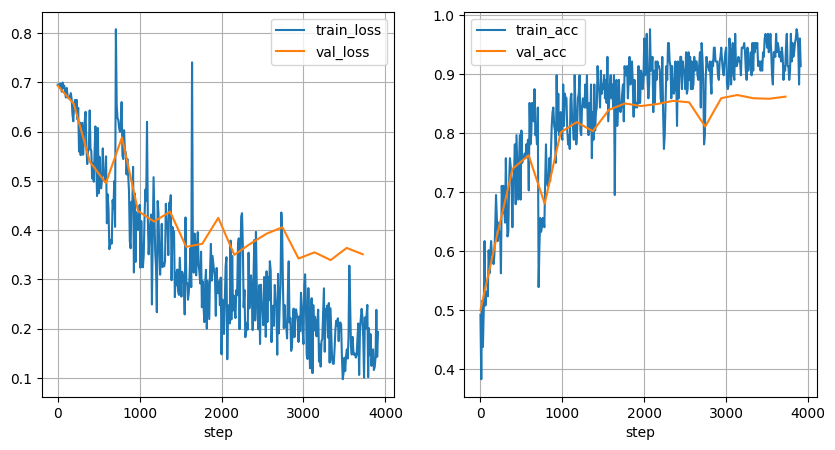

In [26]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()


plot_learning_curves(record, sample_step=10)  #横坐标是 steps

评估

In [27]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/imdb-lstm/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

/tmp/ipykernel_327/1661179837.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/imdb-lstm/best.ckpt", map_location="cpu"))


loss:     0.3551
accuracy: 0.8650


#### 实战LSTM文本生成——基于char level的生成

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


数据准备

In [29]:
# https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
#文件已经下载好了
with open("./shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print("length", len(text))
print(text[0:100])

length 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


构造字典

In [30]:
# 1. generate vocab
# 2. build mapping char->id
# 3. data -> id_data  把数据都转为id
# 4. a b c d [EOS] -> [BOS] b c d  预测下一个字符生成的模型，也就是输入是a，输出就是b

#去重，留下独立字符，并排序
vocab = sorted(set(text))
print(len(vocab))
print(vocab)

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [31]:
#每个字符都编好号，enumerate对每一个位置编号，生成的是列表中是元组，下面字典生成式
char2idx = {char: idx for idx, char in enumerate(vocab)}
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [32]:
# 把vocab从列表变为ndarray
idx2char = np.array(vocab)
print(idx2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [33]:
#把字符都转换为id
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int.shape)
print(len(text_as_int))
print(text_as_int[0:10])
print(text[0:10])

(1115394,)
1115394
[18 47 56 57 58  1 15 47 58 47]
First Citi


把莎士比亚文集分成一个一个的样本

In [34]:
from torch.utils.data import Dataset, DataLoader


class CharDataset(Dataset):
    def __init__(self, text_as_int, seq_length):
        self.sub_len = seq_length + 1
        self.text_as_int = text_as_int
        self.num_seq = len(text_as_int) // self.sub_len

    def __getitem__(self, index):
        return self.text_as_int[index * self.sub_len: (index + 1) * self.sub_len]

    def __len__(self):
        return self.num_seq


def collat_fct(batch):
    src_list = []
    trg_list = []
    for part in batch:
        src_list.append(part[:-1])
        trg_list.append(part[1:])

    src_list = np.array(src_list)
    trg_list = np.array(trg_list)
    return torch.Tensor(src_list).to(dtype=torch.int64), torch.Tensor(trg_list).to(dtype=torch.int64)


train_ds = CharDataset(text_as_int, 100)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collat_fct)

定义模型

In [35]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        x = self.fc(output)
        return x, hidden

In [36]:
vocab_size = len(vocab)
sample_inputs = torch.randint(0, vocab_size, (2, 100))

print("{:=^80}".format(" 一层单向 LSTM "))
for key, value in CharLSTM(vocab_size).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

CharLSTM(vocab_size)(sample_inputs)[0].shape

================================== 一层单向 LSTM ===================================
            embedding.weight            paramerters num: 16640
           lstm.weight_ih_l0            paramerters num: 1048576
           lstm.weight_hh_l0            paramerters num: 4194304
            lstm.bias_ih_l0             paramerters num: 4096
            lstm.bias_hh_l0             paramerters num: 4096
               fc.weight                paramerters num: 66560
                fc.bias                 paramerters num: 65


torch.Size([2, 100, 65])

训练

In [37]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

In [38]:
# 训练
def training(
        model,
        train_loader,
        epoch,
        loss_fct,
        optimizer,
        save_ckpt_callback=None,
        stateful=False  # 想用stateful，batch里的数据就必须连续，不能打乱
):
    record_dict = {
        "train": [],
    }

    global_step = 0
    model.train()
    hidden = None
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits, hidden = model(datas, hidden=hidden if stateful else None)
                # 计算损失
                loss = loss_fct(logits.reshape(-1, vocab_size), labels.reshape(-1))
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # 保存模型权重 save model checkpoint
                if save_ckpt_callback is not None:
                    save_ckpt_callback(global_step, model.state_dict(), metric=-loss)
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict

In [39]:
epoch = 100

model = CharLSTM(vocab_size=vocab_size)

# 1. 定义损失函数 采用交叉熵损失 
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/text_generation_lstm", save_step=1000, save_best_only=True)


In [40]:
model = model.to(device)
record = training(
    model,
    train_dl,
    epoch,
    loss_fct,
    optimizer,
    save_ckpt_callback=save_ckpt_callback,
)

100%|██████████| 17300/17300 [05:03<00:00, 57.09it/s, epoch=99]


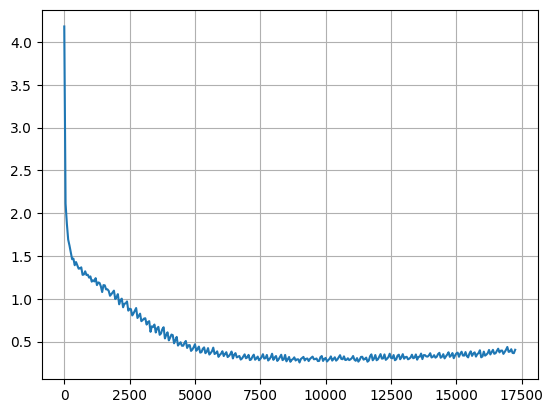

In [41]:
plt.plot([i["step"] for i in record["train"][::50]], [i["loss"] for i in record["train"][::50]], label="train")
plt.grid()
plt.show()

推理

- temperature参数的作用：
    - 1. temperature > 1.0：增加随机性，使概率分布更平滑，生成更多样化的文本
    - 2. temperature = 1.0：保持原始概率分布
    - 3. temperature < 1.0：减少随机性，使概率分布更尖锐，生成更保守、更确定的文本
    - 4. temperature接近0：选择概率最高的字符（贪婪搜索）

In [42]:
#下面的例子是为了说明temperature
logits = torch.tensor([0.4, 0.6])  #这里是logits

probs1 = F.softmax(logits / 1, dim=-1)
print(probs1)

tensor([0.4502, 0.5498])


In [43]:
logits = torch.tensor([0.4, 0.6])  #现在 temperature是2

probs1 = F.softmax(logits / 2, dim=-1)
print(probs1)

tensor([0.4750, 0.5250])


In [44]:
import torch

# 创建一个概率分布，表示每个类别被选中的概率
# 这里我们有一个简单的四个类别的概率分布
prob_dist = torch.tensor([0.1, 0.45, 0.35, 0.1])

# 使用 multinomial 进行抽样
# num_samples 表示要抽取的样本数量
num_samples = 5

# 抽取样本，随机抽样，概率越高，抽到的概率就越高
samples = torch.multinomial(prob_dist, 1, replacement=True)

print("概率分布:", prob_dist)
print("抽取的样本索引:", samples)

# 显示每个样本对应的概率
print("每个样本对应的概率:", prob_dist[samples])

概率分布: tensor([0.1000, 0.4500, 0.3500, 0.1000])
抽取的样本索引: tensor([1])
每个样本对应的概率: tensor([0.4500])


In [47]:
def generate_text(model, start_string, max_len=1000, temperature=1.0, stream=True):
    # 将起始字符串转换为模型输入张量
    # 1. 将每个字符转换为对应的索引
    # 2. 转换为PyTorch张量并指定数据类型为int64
    # 3. 调整形状为(1, seq_len)以适应模型输入要求
    input_eval = torch.Tensor([char2idx[char] for char in start_string]).to(dtype=torch.int64, device=device).reshape(1,
                                                                                                                      -1)

    hidden = None  # 初始化隐藏状态
    text_generated = []  # 用于保存生成的文本
    model.eval()  # 将模型设置为评估模式

    # 初始化进度条，用于显示生成进度
    pbar = tqdm(range(max_len))
    print(start_string, end="")  # 打印起始字符串

    # 使用torch.no_grad()上下文管理器，避免在生成过程中计算梯度
    with torch.no_grad():
        for i in pbar:  # 控制生成进度
            # 前向传播，获取logits和新的隐藏状态
            logits, hidden = model(input_eval, hidden=hidden)

            # 温度采样：调整logits以控制生成文本的多样性
            # 取最后一个时间步的输出（-1表示最后一个时间步）

            #  0表示取第一个batch（因为我们只生成了一个序列）
            # -1表示取最后一个时间步的输出（即最新生成的字符的预测）
            #  :表示取所有可能的字符（即整个词汇表的logits）
            logits = logits[0, -1, :] / temperature

            # 使用softmax将logits转换为概率分布
            probs = F.softmax(logits, dim=-1)

            # 使用多项式采样从概率分布中抽取一个样本
            idx = torch.multinomial(probs, 1).item()

            # 将生成的字符索引转换为输入张量，用于下一次迭代
            input_eval = torch.Tensor([idx]).to(dtype=torch.int64, device=device).reshape(1, -1)

            # 将生成的字符索引添加到结果列表中
            text_generated.append(idx)

            # 如果stream为True，实时打印生成的字符
            if stream:
                print(idx2char[idx], end="", flush=True)

    # 将生成的字符索引列表转换为字符串并返回
    return "".join([idx2char[i] for i in text_generated])


# 加载模型检查点
# 1. 从指定路径加载模型权重
# 2. 使用map_location="cpu"确保在CPU上加载
# 3. weights_only=True确保只加载权重，不加载其他可能不安全的对象
model.load_state_dict(torch.load("./checkpoints/text_generation_lstm/best.ckpt", map_location="cpu", weights_only=True))

# 设置起始字符串
start_string = "All: "  # 可以是任意字符串，作为生成文本的开头

# 生成文本
# max_len: 最大生成长度
# temperature: 温度参数，控制生成文本的多样性
# stream: 是否实时打印生成的文本
res = generate_text(model, start_string, max_len=1000, temperature=0.5, stream=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

All: a

  0%|          | 1/1000 [00:00<01:59,  8.35it/s]

nd I come by him.

PETRUCHIO:
Come on, i' God's name, speak; for what life's I have worn
That you may conquer or sound 

 12%|█▏        | 120/1000 [00:00<00:01, 650.95it/s]

this one:
Come, what letters of Hereford till God's name,
In most I trust my want of water:
And, for the senators, the m

 24%|██▍       | 240/1000 [00:00<00:00, 890.46it/s]

ighty prince,
Lend two the bridgling throne and the fair staring
Than at your walls, as mine hath cheepts to do,
Without a subje

 37%|███▋      | 368/1000 [00:00<00:00, 1038.62it/s]

ct spent, it makes him to it,
The more than his or soul and tears are gone.

CLIFFORD:
The king is nothing: I say the tractless i

 50%|████▉     | 497/1000 [00:00<00:00, 1124.85it/s]

n
the service of your daughter to his will and that with her
sworn.

PROSPERO:
Dost thou, that e'er thou wast but ladies' brawl

 62%|██████▏   | 624/1000 [00:00<00:00, 1172.65it/s]

s,
And what they say that she did lose his life?

GLOUCESTER:
You may deny that for my counsels,
Even thus the very time Aufidius

 75%|███████▌  | 753/1000 [00:00<00:00, 1208.08it/s]

 caps it before
The second cur is but a drunken made
As thou canst gradle carried and sullen venom,
And on athanting them 

 88%|████████▊ | 875/1000 [00:00<00:00, 1127.84it/s]

from France speaks.

Nurse:
Now, afore God! methinks I hear gently for thee.

AUTOLYCUS:
No, good shepherd, will yo

 99%|█████████▉| 990/1000 [00:00<00:00, 1118.25it/s]

u not hure

100%|██████████| 1000/1000 [00:00<00:00, 1039.83it/s]
